In [23]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import disrnn
import rnn_utils
from rnn_utils import DatasetRNN

# Load Data

In [86]:
matDf = loadmat('..\data\data_for_Meike.mat')['data']
features = matDf.dtype.names
df = pd.DataFrame(np.squeeze(np.array(matDf.tolist())).T, columns=features).drop(columns=['label','Spcorrect1', 'Spcorrect2', 'Snoise']).sort_values(by=['subject', 'trial'])

# filter out broken subjects
subject_list = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 29]
df = df[df['subject'].isin(subject_list)]


# # categorical partner type: A for 1, B for 2 in block 1, C for 1, D for 2 in block 2, E for 1, F for 2 in block 3, G for 1, H for 2 in block 4
# df['type'] = np.where(df['block'] == 1, np.where(df['type'] == 1, 'A', 'B'), 
#                 np.where(df['block'] == 2, np.where(df['type'] == 1, 'C', 'D'), 
#                     np.where(df['block'] == 3, np.where(df['type'] == 1, 'E', 'F'), 
#                          np.where(df['type'] == 1, 'G', 'H')))
#             )

df['Reward'] = (df['select'] == 1) * df['Sacc'] + (df['select'] == -1) * df['Pacc']
df['theta'] = np.absolute(df['dtheta'])
df['theta_next'] = df['theta'].shift(periods = 1, fill_value = 0)
df['Sacc_next'] = df['Sacc'].shift(periods = 1, fill_value = 0)

# Create Sconfidence for each subject and each block, relative to mean of Sreport: 1 = Sreport > mean, 0 = Sreport < mean
df['Sconfidence'] = df.groupby(['subject', 'block'])['Sreport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))
df['Pconfidence'] = df.groupby(['subject', 'block'])['Preport'].transform(lambda x: np.where(x >= np.mean(x), 1, 0))
#df['Pconfidence'] = np.where(df['Preport'] > 3, 1, 0)


# Rescale Sreport and Preport to 0-1
df['Sreport_rescaled'] = (df['Sreport'] - 1) / 5
df['Preport_rescaled'] = (df['Preport'] - 1) / 5

 
#features = ['trial', 'theta', 'Preport', 'Pacc', 'Schoice', 'Sacc', 'select', 'Reward', 'Sreport'] 
#features = ['theta', 'Preport_rescaled', 'Pacc', 'Schoice', 'Sacc', 'select', 'Reward', 'Sreport_rescaled']
features = ['block', 'type', 'theta', 'Pconfidence', 'Pacc', 'Schoice', 'Sacc', 'select', 'Reward', 'Sconfidence'] 

# Create target: for a given index in df, find the next index that has the same value for df['type'] and add df['Sconfidence'] of that index to the target
target = []
# assert that target has the same length as df, i.e. that i == len(target)

for i in range(len(df)):
    for j in range(i+1, len(df)):
        if df['subject'].iloc[i] == df['subject'].iloc[j] and df['block'].iloc[i] == df['block'].iloc[j] and df['type'].iloc[i] == df['type'].iloc[j]:
            target.append(df['Sconfidence'].iloc[j])
            break

        # if the next trial is the first one of the next block, append -1
        elif df['subject'].iloc[i] == df['subject'].iloc[j] and (df['block'].iloc[i] + 1) == df['block'].iloc[j]:
            target.append(-1)
            break

        # if the next trial is the first one of the next subject, append -1
        elif (subject_list.index(df['subject'].iloc[i])+1 < len(subject_list)) and (subject_list[subject_list.index(df['subject'].iloc[i])+1]) == df['subject'].iloc[j] and df['block'].iloc[i] == 4 and df['block'].iloc[j] == 1:
            target.append(-1)
            break
# no target for the last two trials, append -1 twice    
target.append(-1)
target.append(-1)

In [46]:
df

,subject,block,trial,dtheta,type,Pchoice,Preport,Pacc,Schoice,Sreport,...,Srt2,select,Reward,theta,theta_next,Sacc_next,Sconfidence,Pconfidence,Sreport_rescaled,Preport_rescaled
0,1.0,1.0,1.0,0.18,2.0,-1.0,5.0,0.0,1.0,3.0,...,2576.0,-1.0,0.0,0.18,0.00,0.0,0,1,0.4,0.8
1,1.0,1.0,2.0,-0.11,2.0,-1.0,6.0,1.0,-1.0,4.0,...,1483.0,-1.0,1.0,0.11,0.18,1.0,1,1,0.6,1.0
2,1.0,1.0,3.0,-0.27,1.0,-1.0,3.0,1.0,-1.0,6.0,...,940.0,1.0,1.0,0.27,0.11,1.0,1,0,1.0,0.4
3,1.0,1.0,4.0,0.18,2.0,1.0,6.0,1.0,1.0,5.0,...,1505.0,-1.0,1.0,0.18,0.27,1.0,1,1,0.8,1.0
4,1.0,1.0,5.0,0.05,1.0,-1.0,3.0,0.0,1.0,1.0,...,665.0,-1.0,0.0,0.05,0.18,1.0,0,0,0.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7419,29.0,4.0,252.0,-0.28,1.0,-1.0,2.0,1.0,-1.0,4.0,...,2391.0,1.0,1.0,0.28,0.46,1.0,0,0,0.6,0.2
7420,29.0,4.0,253.0,-0.70,2.0,-1.0,5.0,1.0,-1.0,5.0,...,1020.0,-1.0,1.0,0.70,0.28,1.0,1,1,0.8,0.8
7421,29.0,4.0,254.0,0.70,2.0,1.0,4.0,1.0,1.0,5.0,...,3760.0,1.0,1.0,0.70,0.70,1.0,1,1,0.8,0.6
7422,29.0,4.0,255.0,0.46,2.0,1.0,3.0,1.0,1.0,6.0,...,1910.0,1.0,1.0,0.46,0.70,1.0,1,0,1.0,0.4


# Create All and Test

In [80]:
batch_size = None
tr = 4 # where to split between train and test set when not doing LOOCV
LOOCV = True # set to true if you want to do leave-one-out cross validation
leave_out_idx = 0 # index of the subject to leave out
block_dim = False

if block_dim:
    
    target_size = df['Sconfidence'].unique().size
    n_subjects = df['subject'].unique().size
    n_blocks = df['block'].unique().size
    n_trials = int(len(df) / (n_subjects*n_blocks))
    features_number = len(features)
    
    xsTrain = np.zeros((n_trials, n_blocks, n_subjects, features_number))
    ysTrain = np.zeros((n_trials, n_blocks, n_subjects, 1))
    xsTest = np.zeros((n_trials, n_blocks, 1, features_number))
    ysTest = np.zeros((n_trials, n_blocks, 1, 1))

    for i, subject in enumerate(np.sort(df['subject'].unique())):
        for j, block in enumerate(np.sort(df['block'].unique())):
            xsTrain[:, j, i, :] = df[(df['subject'] == subject) & (df['block'] == block)][features].values
        
    # reshape target to fit the shape of ysTrain
    ysTrain = np.array(target).reshape(n_trials, n_blocks, n_subjects, 1)
    
    # The test set consists of the subject that is left out
    xsTest[:, :, 0, :] = xsTrain[:, :, leave_out_idx, :]
    ysTest[:, :, 0, :] = ysTrain[:, :, leave_out_idx, :]    
        
    # Exclude leave_out_idx from xsTrain and ysTrain
    xsTrain = np.delete(xsTrain, leave_out_idx, axis=2)
    ysTrain = np.delete(ysTrain, leave_out_idx, axis=2)
    

    train = DatasetRNN(xsTrain, ysTrain, batch_size)
    test = DatasetRNN(xsTest, ysTest, batch_size)


elif LOOCV:
    target_size = df['Sconfidence'].unique().size
    n_subjects = df['subject'].unique().size
    n_trials = int(len(df) / n_subjects)
    n_blocks = df['block'].unique().size
    features_number = len(features)
    
    xsTrain = np.zeros((n_trials, n_subjects, features_number))
    ysTrain = np.zeros((n_trials, n_subjects, 1))
    xsTest = np.zeros((n_trials, 1, features_number))
    ysTest = np.zeros((n_trials, 1, 1))

    for i, subject in enumerate(np.sort(df['subject'].unique())):
        xsTrain[:, i, :] = df[df['subject'] == subject][features].values
        
    # reshape target to fit the shape of ysTrain
    ysTrain = np.array(target).reshape(n_trials, n_subjects, 1, order='F')
    
    # The test set consists of the subject that is left out
    xsTest[:, 0, :] = xsTrain[:, leave_out_idx, :]
    ysTest[:, 0, :] = ysTrain[:, leave_out_idx, :]    
        
    # Exclude leave_out_idx from xsTrain and ysTrain
    xsTrain = np.delete(xsTrain, leave_out_idx, axis=1)
    ysTrain = np.delete(ysTrain, leave_out_idx, axis=1)

    n_subjects -= 1

    # division between blocks
    border = int(n_trials / len(df['block'].unique())) # number of trials per block
    indices = np.arange(border, n_blocks * border, border)
    
    # Add a dummy between the blocks
    xsTrain_padded_LOOCV = np.insert(xsTrain, indices, np.zeros((1, n_subjects, features_number)), axis=0)
    xsTest_padded_LOOCV = np.insert(xsTest, indices, np.zeros((1, 1, features_number)), axis=0)
    # The targets already contain -1s, but we need to add one more to seperate the blocks
    ysTrain_padded_LOOCV  = np.insert(ysTrain, indices, -1*np.ones((1, n_subjects, 1)), axis=0)
    ysTest_padded_LOOCV = np.insert(ysTest, indices, -1*np.ones((1, 1, 1)), axis=0)

    train = DatasetRNN(xsTrain_padded_LOOCV, ysTrain_padded_LOOCV, batch_size)
    test = DatasetRNN(xsTest_padded_LOOCV, ysTest_padded_LOOCV, batch_size)


    
else: 

    df_test = df[df['block'] >= tr]
    df_train = df[df['block'] < tr]

    n_trials_train = df_train['trial'].unique().size
    n_trials_test = df_test['trial'].unique().size
    target_size = df['Sreport'].unique().size
    n_subjects = df['subject'].unique().size 
    n_blocks = df['block'].unique().size
    features_number = len(features)

    xsTrain = np.zeros((n_trials_train, n_subjects, features_number))
    ysTrain = np.zeros((n_trials_train, n_subjects, 1))
    xsTest = np.zeros((n_trials_test, n_subjects, features_number))
    ysTest = np.zeros((n_trials_test, n_subjects, 1))

    for i, subject in enumerate(df['subject'].unique()):    
        xsTrain[:, i, :] = df_train[df_train['subject'] == subject][features].values
        ysTrain[:, i, :] = df_train[df_train['subject'] == subject][target].values
        xsTest[:, i, :] = df_test[df_test['subject'] == subject][features].values
        ysTest[:, i, :] = df_test[df_test['subject'] == subject][target].values    
        
    border = int(n_trials_train / len(df_train['block'].unique()))
    indices_xsTrain = np.arange(0, (tr - 1) * border, border)
    indices_xsTest = np.arange(0, (n_blocks - tr) * border + 1, border)
    indices_ysTrain = np.arange(border, (tr - 1) * border, border)
    indices_ysTest = np.arange(0, (n_blocks - tr) * border, border)

    # Add a dummy input at the beginning of each block. First step has a target but no input
    xsTrain_padded = np.insert(xsTrain, indices_xsTrain, np.zeros((1, n_subjects, features_number)), axis=0)   
    xsTest_padded = np.insert(xsTest, indices_xsTest, np.zeros((1, n_subjects, features_number)), axis=0)

    # Add a dummy target at the end of each block. Last step has input but no target
    ysTrain_padded = np.insert(ysTrain, indices_ysTrain, -1*np.ones((1, n_subjects, 1)), axis=0)
    ysTest_padded = np.insert(ysTest, indices_ysTest, -1*np.ones((1, n_subjects, 1)), axis=0)

    # np.insert inserts before given idx, so the last row we need to append manually
    ysTrain_padded = np.concatenate((ysTrain_padded, -1*np.ones((1,n_subjects,1))), axis=0)
    ysTest_padded = np.concatenate((ysTest_padded, -1*np.ones((1,n_subjects,1))), axis=0)

    train = DatasetRNN(xsTrain_padded, ysTrain_padded, batch_size)
    test = DatasetRNN(xsTest_padded, ysTest_padded, batch_size)

In [81]:
xsTrain_padded_LOOCV.shape

(259, 21, 10)

Set up Disentangled RNN

In [82]:
xsTrain.shape, ysTrain.shape, xsTest.shape, ysTest.shape

((256, 21, 10), (256, 21, 1), (256, 1, 10), (256, 1, 1))

In [84]:
latent_size = 5
obs_size = xsTrain.shape[-1]

# Number of hidden units in each of the two layers of the choice MLP.
#update_mlp_shape = (5, 5, 5)  
#choice_mlp_shape = (5, 5, 5)  
update_mlp_shape = (features_number,features_number,) # input layer: number of features, hidden layer: different number possible but start with 8,8 here
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(
      obs_size = obs_size,
      latent_size = latent_size,
      update_mlp_shape = update_mlp_shape,
      choice_mlp_shape = choice_mlp_shape,
      target_size=target_size)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(
          obs_size = obs_size,
          latent_size = latent_size,
          update_mlp_shape = update_mlp_shape,
          choice_mlp_shape = choice_mlp_shape,
          target_size=target_size,
          eval_mode=True)                  
  return model

optimizer = optax.adam(learning_rate=1e-2)

Fit disRNN with no penalty at first, to get good quality-of-fit

In [85]:
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=200,
)

KeyboardInterrupt: 

Step 3000 of 3000; Loss: nan. (Time: 202.3s){'hk_dis_rnn': {'latent_inits': Array([nan, nan, nan, nan, nan], dtype=float32), 'latent_sigmas_unsquashed': Array([nan, nan, nan, nan, nan], dtype=float32), 'update_mlp_gates': Array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32), 'update_mlp_sigmas_unsquashed': Array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, na

ValueError: NaN in params

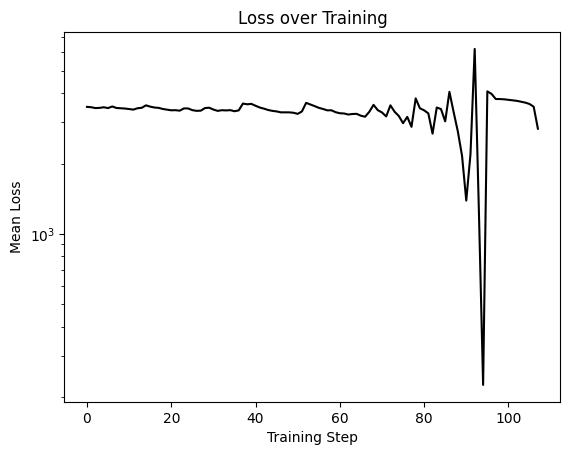

In [46]:
# Now fit more steps with a penalty, to encourage it to find a simple solution
# You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3 #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

Visualize model latents

In [10]:
# Visualize bottleneck latents + learned update.
#disrnn.plot_bottlenecks(disrnn_params, obs_names=features)
#disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)


# Calculate Normalized likelihoods

In [11]:
def compute_log_likelihood(dataset, model_fun, params):
  """Computes the log likelihood of the dataset under the model and the parameters.
  (the probability each choice we see in the dataset would have occurred in the model)
  
  Args:
    dataset: A DatasetRNN object.
    model_fun: A Haiku function that defines a network architecture.
    params: A set of params suitable for that network.
  """
  
  # It returns the normalized likelihood of the dataset under the model and the parameters as an output
  xs, actual_choices = next(dataset)
  n_trials_per_session, n_subjects = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  # Computes the logarithm of the softmax function, which rescales elements to the range [-infinity,0)
  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :-1])) # last entry is nans

  # Scale actual_choices back to the range [0,5] to match the indices
  #values = np.arange(1,7)
  #actual_choices_rescaled = actual_choices * (max(values) - min(values)) + min(values)

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_subjects):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])-1 # to match indices because choices are 1-6
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

In [12]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(
    train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(
    test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset


Normalized Likelihood: 47.2%
Held-Out Dataset
Normalized Likelihood: 47.7%


## Plot the choices made by the model and the actual choices.

In [13]:
xs, actual_choices = next(test) # performance for the training set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = model_outputs[:, :, :-1]  # Last entry is nans.
#predicted_choices = np.argmax(model_outputs, axis=-1) + 1  # +1 to match indices because choices are 1-6, not needed in binary case

In [32]:
import pickle
with open('..\data\model_outputs.pkl', 'wb') as f:
        pickle.dump(model_outputs, f)

In [36]:
# load model outputs
with open('..\data\model_outputs.pkl', 'rb') as f:
        abc = pickle.load(f)


(259, 30, 2)

In [14]:
# model_outputs_reshaped = model_outputs.reshape(model_outputs.shape[0], -1)

# np.savetxt("..\data\model_outputs.csv", model_outputs_reshaped, delimiter=",")

# model_outputs_loaded = np.loadtxt("..\data\model_outputs_partner1.csv", delimiter=",")
 
# model_outputs_loaded = model_outputs_loaded.reshape((model_outputs.shape[0], model_outputs.shape[1], model_outputs.shape[2]))


Plot the model predictions

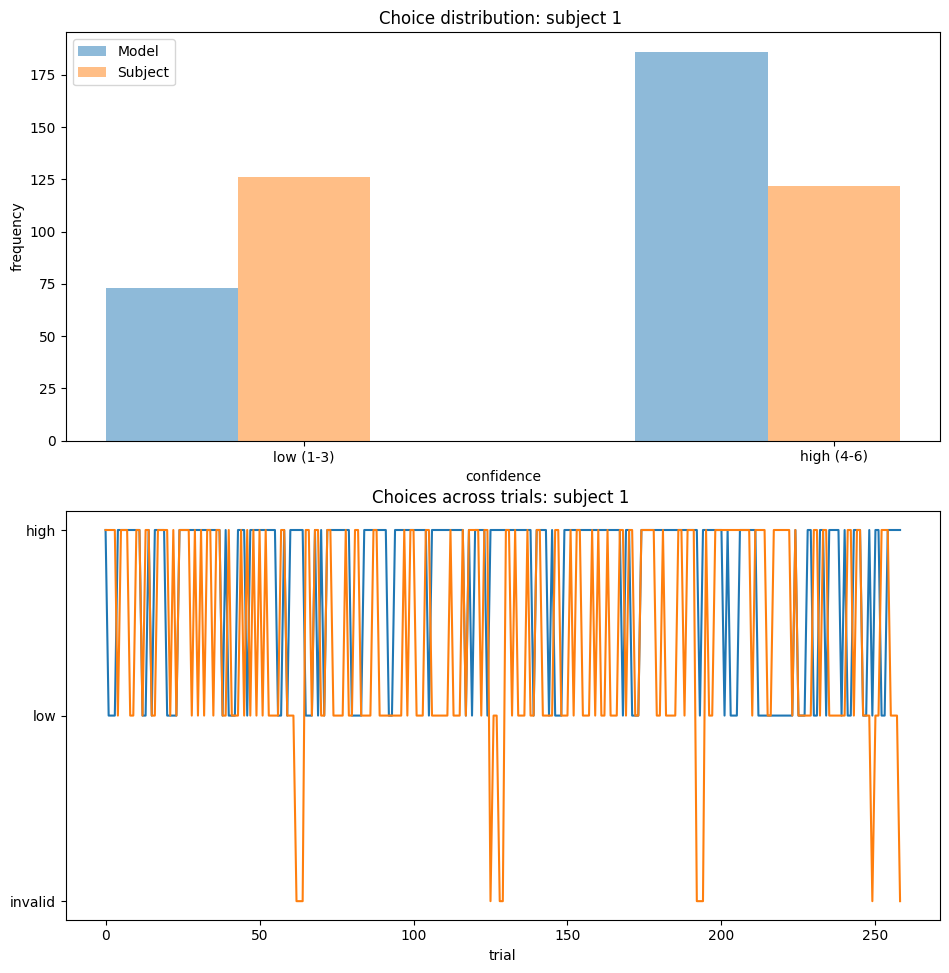

In [15]:

for i in range(model_outputs.shape[1]):

    model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
    model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))

    subject_choice = actual_choices[:, i]
    subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
    
    # Plot the distribution of choices for each subject
    labels = ("low (1-3)", "high (4-6)")
    all_choices = {'Model': model_counts, 'Subject': subject_counts}
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    #fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig, ax = plt.subplots(2, 1, figsize = (10, 10))
    fig.tight_layout(pad=3.0)

    for identity, count in all_choices.items():
        offset = width * multiplier
        rects = ax[0].bar(x + offset, count, width, alpha=0.5, label=identity)
        multiplier += 1

    ax[0].set_ylabel('frequency')
    ax[0].set_xlabel('confidence')
    ax[0].set_title('Choice distribution: subject {subject} '.format(subject=i+1))
    ax[0].set_xticks(x + width, labels)
    ax[0].legend(loc='upper left')
    
    # Plot the choices across all trials
    ax[1].plot(model_choice, label='Model')
    ax[1].plot(subject_choice, label='Subject')
    
    ax[1].set_xlabel('trial')
    ax[1].set_yticks([-1,0,1], labels=['invalid', 'low', 'high'])
    ax[1].set_title('Choices across trials: subject {subject} '.format(subject=i+1))

    plt.show()

# Prepare dataset with all subjects

In [16]:
n_subjects = df['subject'].unique().size
n_trials = int(len(df) / n_subjects)
n_blocks = df['block'].unique().size
features_number = len(features)

xsAll = np.zeros((n_trials, n_subjects, features_number))
ysAll = np.zeros((n_trials, n_subjects, 1))

for i, subject in enumerate(np.sort(df['subject'].unique())):
    xsAll[:, i, :] = df[df['subject'] == subject][features].values
    
# Reshape target to fit the shape of ysAll
ysAll = np.array(target).reshape(n_trials, n_subjects, 1, order='F')

# division between blocks
border = int(n_trials / len(df['block'].unique())) # number of trials per block
indices = np.arange(border, n_blocks * border, border)

# Add a dummy between the blocks
xsAll_padded = np.insert(xsAll, indices, np.zeros((1, n_subjects, features_number)), axis=0)
ysAll_padded = np.insert(ysAll, indices, -1*np.ones((1, n_subjects, 1)), axis=0)

datasetAll = DatasetRNN(xsAll_padded, ysAll_padded, batch_size)

Extract trials were partner 1 and 2 were encountered for each subject

In [17]:
t1 = np.unique(xsAll_padded[:, 0, 1], return_counts=True)[1][1]
t2 = np.unique(xsAll_padded[:, 0, 1], return_counts=True)[1][2]

idx_partner1 = np.zeros((t1, n_subjects))
idx_partner2 = np.zeros((t2, n_subjects))

for i in range(n_subjects):
    idx_partner1[:, i] = np.argwhere(xsAll_padded[:, i, 1] == 1)[:,0]
    idx_partner2[:, i] = np.argwhere(xsAll_padded[:, i, 1] == 2)[:,0]

idx_partner1.shape, idx_partner2.shape

((128, 30), (128, 30))

In [18]:
# Filter arrays by trials of partner 1 and partner 2
xsAll_partner1 = np.zeros((t1, n_subjects, features_number))
xsAll_partner2 = np.zeros((t2, n_subjects, features_number))
ysAll_partner1 = np.zeros((t1, n_subjects, 1))
ysAll_partner2 = np.zeros((t2, n_subjects, 1))

for i in range(n_subjects):
    xsAll_partner1[:,i,:] = xsAll_padded[idx_partner1.astype(int)[:,i], i, :]
    xsAll_partner2[:,i,:] = xsAll_padded[idx_partner2.astype(int)[:,i], i, :]
    ysAll_partner1[:,i,:] = ysAll_padded[idx_partner1.astype(int)[:,i], i, :]
    ysAll_partner2[:,i,:] = ysAll_padded[idx_partner2.astype(int)[:,i], i, :]

In [19]:
xsAll_partner1.shape, xsAll_partner2.shape, ysAll_partner1.shape, ysAll_partner2.shape

((128, 30, 10), (128, 30, 10), (128, 30, 1), (128, 30, 1))

## Plot the models prediction

In [20]:
xs, actual_choices = next(datasetAll)
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = model_outputs[:, :, :-1]  # Last entry is nans.


In [21]:
jnp.sum(model_outputs[:, :, -1])

Array(-2719958.8, dtype=float32)

In [22]:
model_outputs.shape

(259, 30, 2)

In [23]:
# Filter array by trials of partner 1 and partner 2

model_outputs_partner1 = np.zeros((t1, n_subjects, 2))
model_outputs_partner2 = np.zeros((t2, n_subjects, 2))

for i in range(n_subjects):
    model_outputs_partner1[:,i,:] = model_outputs[idx_partner1.astype(int)[:,i], i, :]
    model_outputs_partner2[:,i,:] = model_outputs[idx_partner2.astype(int)[:,i], i, :]

In [24]:
model_outputs_partner1.shape, model_outputs_partner2.shape

((128, 30, 2), (128, 30, 2))

In [25]:
# Plot the models prediction for partner 1 and partner 2
predicted_choices_partner1 = np.argmax(model_outputs_partner1, axis=-1)
predicted_choices_partner2 = np.argmax(model_outputs_partner2, axis=-1)
predicted_choices_partner1.shape, predicted_choices_partner2.shape

((128, 30), (128, 30))

In [26]:
Mconf_partner1 = np.mean(predicted_choices_partner1, axis=1)
Mconf_partner2 = np.mean(predicted_choices_partner2, axis=1)
Mconf_SE_partner1 = np.std(predicted_choices_partner1, axis=1) / np.sqrt(n_subjects)
Mconf_SE_partner2 = np.std(predicted_choices_partner2, axis=1) / np.sqrt(n_subjects)
Mconf_partner1.shape, Mconf_partner2.shape

((128,), (128,))

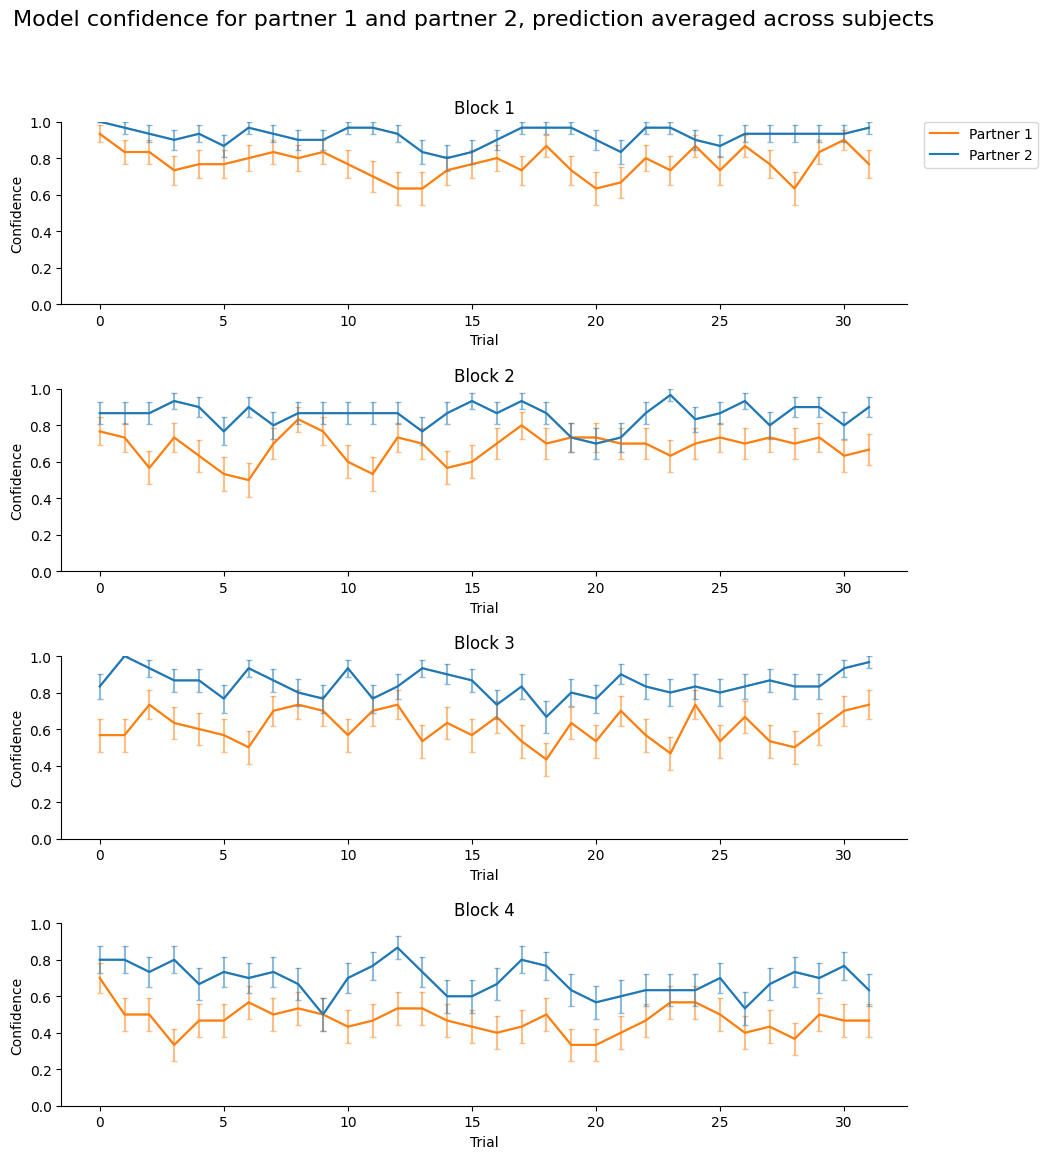

In [27]:
# Plot the models prediction for partner 1 and partner 2
n_trials_per_block = int(len(df) / (n_subjects*n_blocks*2))

fig, axs = plt.subplots(4, 1, figsize = (10, 12))
fig.suptitle('Model confidence for partner 1 and partner 2, prediction averaged across subjects', fontsize=16)
fig.tight_layout(pad=4.0)
x = np.arange(n_trials_per_block)
for i, ax in enumerate(axs.flat):
    ax.plot(Mconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Partner 1', c='tab:orange')
    ax.errorbar(x, Mconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Mconf_SE_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:orange', ecolor=None, alpha=0.5, capsize=2)
    ax.plot(Mconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Partner 2', c='tab:blue')
    ax.errorbar(x, Mconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Mconf_SE_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], ecolor=None, alpha=0.5, capsize=2)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Confidence')
    ax.set_title('Block {block}'.format(block=i+1))
    ax.set_ylim([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    



## Plot human behavior

In [28]:
Sconf_partner1 = np.mean(xsAll_partner1[:, :, 9], axis=1) #idx 0 if ys
Sconf_partner2 = np.mean(xsAll_partner2[:, :, 9], axis=1)
Sconf_SE_partner1 = np.std(xsAll_partner1[:, :, 9], axis=1) / np.sqrt(n_subjects)
Sconf_SE_partner2 = np.std(xsAll_partner2[:, :, 9], axis=1) / np.sqrt(n_subjects)
Sconf_partner1.shape, Sconf_partner2.shape, Sconf_SE_partner1.shape, Sconf_SE_partner2.shape

((128,), (128,), (128,), (128,))

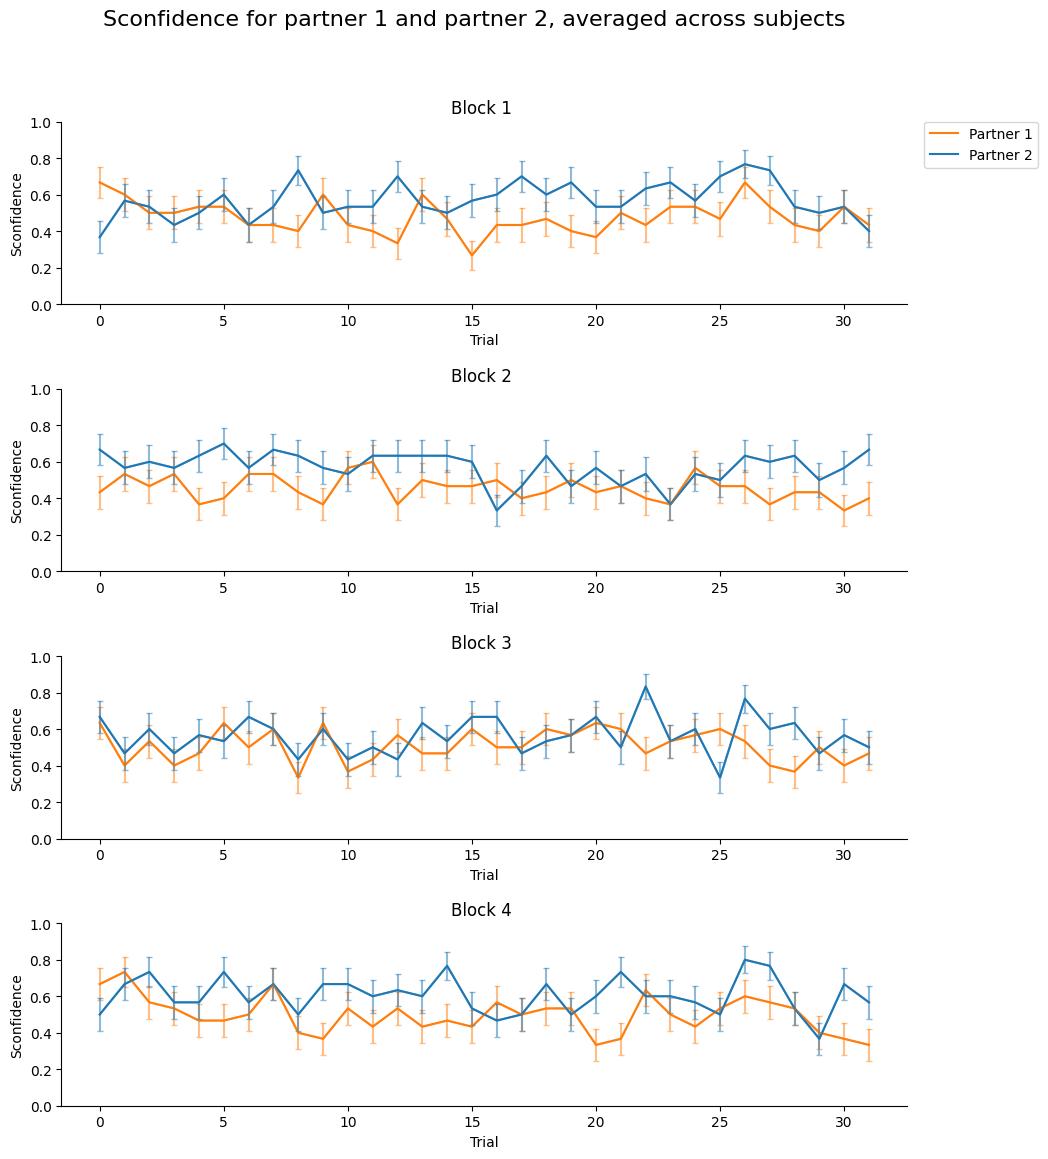

In [29]:
# Plot Sconfidence for partner 1 and partner 2
n_trials_per_block = int(len(df) / (n_subjects*n_blocks*2))

fig, axs = plt.subplots(4, 1, figsize=(10, 12))
fig.suptitle('Sconfidence for partner 1 and partner 2, averaged across subjects', fontsize=16)
fig.tight_layout(pad=4.0)
x = np.arange(n_trials_per_block)
for i, ax in enumerate(axs.flat):
    ax.plot(Sconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Partner 1', c='tab:orange')
    ax.errorbar(x, Sconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Sconf_SE_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:orange', ecolor=None, alpha=0.5, capsize=2)
    
    ax.plot(Sconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Partner 2')
    ax.errorbar(x, Sconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Sconf_SE_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:blue', ecolor=None, alpha=0.5, capsize=2)

    ax.set_xlabel('Trial')
    ax.set_ylabel('Sconfidence')
    ax.set_ylim([0,1])
    ax.set_title('Block {block} '.format(block=i+1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)





## Plot both in the same plot

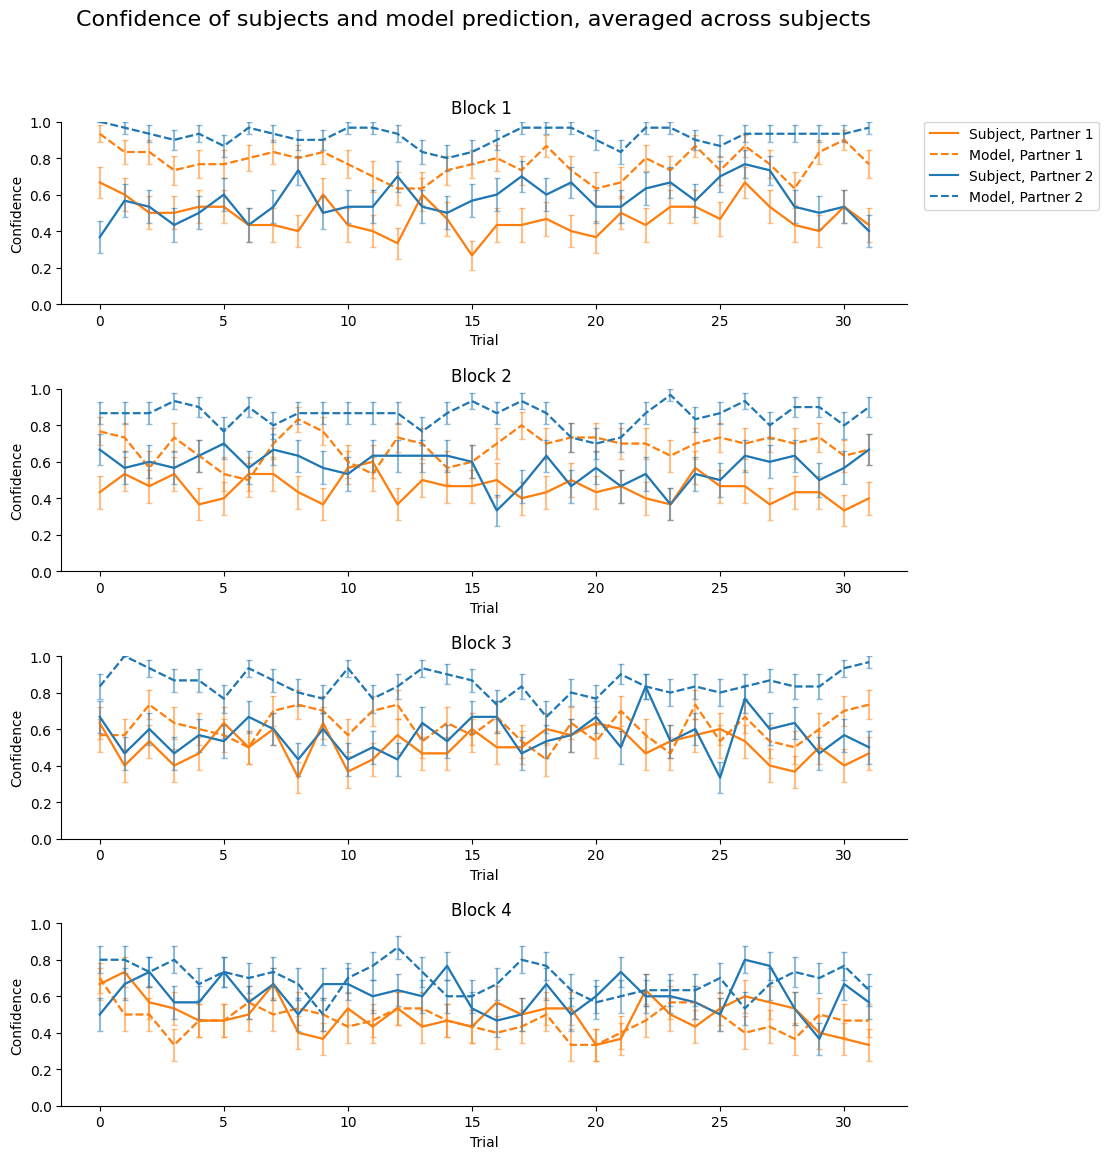

In [30]:
# Plot Sconfidence for partner 1 and partner 2
n_trials_per_block = int(len(df) / (n_subjects*n_blocks*2))

fig, axs = plt.subplots(4, 1, figsize=(10, 12))
fig.suptitle('Confidence of subjects and model prediction, averaged across subjects', fontsize=16)
fig.tight_layout(pad=4.0)
x = np.arange(0, n_trials_per_block, 1)

for i, ax in enumerate(axs.flat):
    ax.plot(Sconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Subject, Partner 1', color='tab:orange')
    ax.errorbar(x, Sconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Sconf_SE_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:orange', ecolor=None, alpha=0.5, capsize=2)
    
    ax.plot(Mconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Model, Partner 1', color='tab:orange', linestyle='dashed')
    ax.errorbar(x, Mconf_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Mconf_SE_partner1[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:orange', linestyle='dashed', ecolor=None, alpha=0.5, capsize=2)
    
    ax.plot(Sconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Subject, Partner 2', color='tab:blue')
    ax.errorbar(x, Sconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Sconf_SE_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:blue', ecolor=None, alpha=0.5, capsize=2)
    
    ax.plot(Mconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], label='Model, Partner 2', color='tab:blue', linestyle='dashed')
    ax.errorbar(x, Mconf_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], yerr=Mconf_SE_partner2[i*n_trials_per_block:(i+1)*n_trials_per_block], c='tab:blue', linestyle='dashed', ecolor=None, alpha=0.5, capsize=2)
    
    ax.set_xlabel('Trial') 
    ax.set_ylabel('Confidence')
    ax.set_ylim([0,1])
    ax.set_title('Block {block} '.format(block=i+1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


   
